In [ ]:
import yfinance as yf
import pandas as pd

ticker = yf.Ticker('GLD')
hist = ticker.history(start='1971-01-01') # seria a justificativa porque foi quando o preço do ouro começou a ser mensurado oficialmente com o fim do preço fixo

In [ ]:
# vamos querer o preço de fechamento apenas
df = hist['Close']
df

Date
2004-11-18 00:00:00-05:00     44.380001
2004-11-19 00:00:00-05:00     44.779999
2004-11-22 00:00:00-05:00     44.950001
2004-11-23 00:00:00-05:00     44.750000
2004-11-24 00:00:00-05:00     45.049999
                                ...    
2026-02-18 00:00:00-05:00    458.279999
2026-02-19 00:00:00-05:00    459.559998
2026-02-20 00:00:00-05:00    468.619995
2026-02-23 00:00:00-05:00    481.279999
2026-02-24 00:00:00-05:00    474.609985
Name: Close, Length: 5349, dtype: float64

In [ ]:
# percebe-se que temos dados a partir de 18/11/2004, então vamos trabalhar a partir de 2005 até 2025, um período de 20 anos para ficar fechado

In [18]:
df = ticker.history(start='2005-01-01', end='2026-01-01')['Close']
df

Date
2005-01-03 00:00:00-05:00     43.020000
2005-01-04 00:00:00-05:00     42.740002
2005-01-05 00:00:00-05:00     42.669998
2005-01-06 00:00:00-05:00     42.150002
2005-01-07 00:00:00-05:00     41.840000
                                ...    
2025-12-24 00:00:00-05:00    411.929993
2025-12-26 00:00:00-05:00    416.739990
2025-12-29 00:00:00-05:00    398.600006
2025-12-30 00:00:00-05:00    398.890015
2025-12-31 00:00:00-05:00    396.309998
Name: Close, Length: 5283, dtype: float64

In [37]:
# vamos calcular os retornos no lugar dos preços
# a ideia é usar log(Pt) - log(Pt-1)
import numpy as np

returns = (100 * np.log(df/df.shift(1))).dropna()
returns

Date
2005-01-04 00:00:00-05:00   -0.652985
2005-01-05 00:00:00-05:00   -0.163923
2005-01-06 00:00:00-05:00   -1.226133
2005-01-07 00:00:00-05:00   -0.738190
2005-01-10 00:00:00-05:00    0.262563
                               ...   
2025-12-24 00:00:00-05:00   -0.414265
2025-12-26 00:00:00-05:00    1.160909
2025-12-29 00:00:00-05:00   -4.450408
2025-12-30 00:00:00-05:00    0.072730
2025-12-31 00:00:00-05:00   -0.648900
Name: Close, Length: 5282, dtype: float64

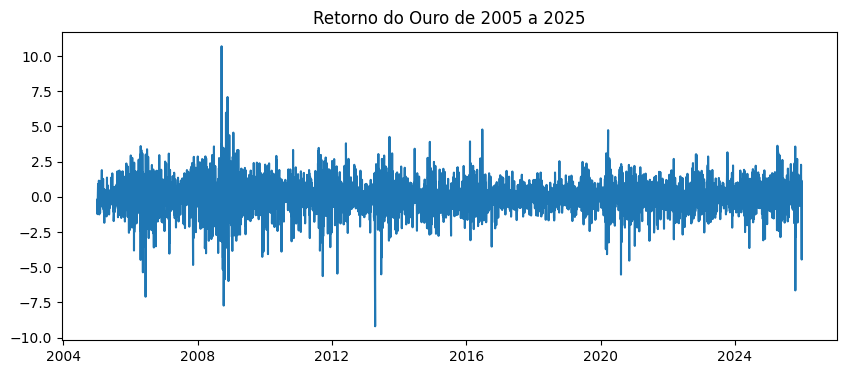

In [ ]:
# visualizando a série
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(returns)
plt.title('Retorno do Ouro de 2005 a 2025')
plt.show()

In [44]:
# vamos agora aplicar os testes de ljung-box (autocorrelação) e arch-lm (heterocedasticidade)
# pegando os residuos através do arima, supondo que a série é estacionária (1,0,1)

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(returns, order=(1,0,1))
res = model.fit()
residuals = res.resid
residuals

c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


Date
2005-01-04 00:00:00-05:00   -0.695027
2005-01-05 00:00:00-05:00   -0.216013
2005-01-06 00:00:00-05:00   -1.274637
2005-01-07 00:00:00-05:00   -0.800898
2005-01-10 00:00:00-05:00    0.202042
                               ...   
2025-12-24 00:00:00-05:00   -0.426371
2025-12-26 00:00:00-05:00    1.122570
2025-12-29 00:00:00-05:00   -4.474906
2025-12-30 00:00:00-05:00   -0.028562
2025-12-31 00:00:00-05:00   -0.710955
Length: 5282, dtype: float64

In [45]:
# agora com residuos vamos usar o ljung-box
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(residuals, lags=[10], return_df=True)

# como o p-valor deu > 0.05, não rejeitamos H0 e os resíduos não estão autocorrelacionados

,lb_stat,lb_pvalue
10,5.899449,0.823639


In [46]:
# agora com arch-lm
from statsmodels.stats.diagnostic import het_arch

het_arch(residuals)

# nesse caso o pvalor do LM (segundo valor) foi < 0.05 e o pvalor do F também, logo o efeito ARCH existe

(np.float64(334.4490385716234),
 np.float64(7.920503319635879e-66),
 35.635812281647745,
 4.43360564055647e-68)

In [ ]:
# Vamos então gerar o modelo arch, nesse caso vamos ver até com quantos p a gente usa através do AIC

from arch import arch_model

best_aic = [float("inf"), None]
best_bic = [float("inf"), None]

for p in range (1,11):
    model = arch_model(df, vol="ARCH", p=p)
    res = model.fit(disp="off")

    if res.aic < best_aic[0]:
        best_aic = [res.aic, p]
    
    if res.bic < best_bic[0]:
        best_bic = [res.bic, p]
    

print(best_aic, best_bic)

# Nsse caso o melhor AIC e BIC foi 1 então vamos usar ARCH(1)

[47555.83322001604, 1] [np.float64(47575.54996820753), 1]


In [50]:
model = arch_model(returns, vol="ARCH", p=1)
res = model.fit()
print(res.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 830788.0187289584
Iteration:      2,   Func. Count:     13,   Neg. LLF: 9208.317579130982
Iteration:      3,   Func. Count:     20,   Neg. LLF: 8077.340650634743
Iteration:      4,   Func. Count:     26,   Neg. LLF: 7978.776133424642
Iteration:      5,   Func. Count:     30,   Neg. LLF: 7978.776129328731
Iteration:      6,   Func. Count:     33,   Neg. LLF: 7978.776129328713
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7978.776129328731
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7978.78
Distribution:                  Normal   AIC: 

In [56]:
# verificando se o modelo capturou heterocedasticidade
het_arch(res.resid)

(np.float64(336.70730772037547),
 np.float64(2.630242118785064e-66),
 35.892848841325225,
 1.3669631601607588e-68)

In [64]:
# vamos usar GARCH agora para ver, já que o modelo apresenta pvalor < 0.05, logo tem heterocedasticidade ainda

model = arch_model(returns, vol="GARCH", p=1, q=1)
res = model.fit()
res.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 14224298399.146238
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2258046393.9352393
Iteration:      3,   Func. Count:     23,   Neg. LLF: 11438.81725595069
Iteration:      4,   Func. Count:     30,   Neg. LLF: 7591.087504127243
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10578.698478815972
Iteration:      6,   Func. Count:     42,   Neg. LLF: 7565.2391895846495
Iteration:      7,   Func. Count:     48,   Neg. LLF: 7569.18486587834
Iteration:      8,   Func. Count:     54,   Neg. LLF: 7553.993313998404
Iteration:      9,   Func. Count:     60,   Neg. LLF: 7553.205768864452
Iteration:     10,   Func. Count:     66,   Neg. LLF: 7553.195018673799
Iteration:     11,   Func. Count:     71,   Neg. LLF: 7553.194692826788
Iteration:     12,   Func. Count:     75,   Neg. LLF: 7553.1946928287625
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7553.194692826788
            Iterations: 

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7553.19
Distribution:                  Normal   AIC:                           15114.4
Method:            Maximum Likelihood   BIC:                           15140.7
                                        No. Observations:                 5282
Date:                Wed, Feb 25 2026   Df Residuals:                     5281
Time:                        23:29:51   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0276  1.320e-02      2.092  3.645e-02 [1.740e-03,5.347e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0138  5.408e-03      2.556  1.058e-02 [3.225e-03,2.442e-02]
alpha[1]       0.0573  1.313e-02      4.363  1.283e-05 [3.156e-02,8.304e-02]
beta[1]        0.9324  1.564e-02     59.606      0.000     [  0.902,  0.963]
============================================================================

Covariance estimator: robust
"""

In [ ]:
# testando agora com garch

het_arch(res.resid)

# percebemos que ainda há o efeito arch, mas como é raro o modelo conseguir zerar isso, podemos aceitar tendo em mente que a ideia seria testar outras coisas para ver como ficaria

(np.float64(336.86435756395986),
 np.float64(2.436116203725171e-66),
 35.910733028387284,
 1.2595280906673936e-68)

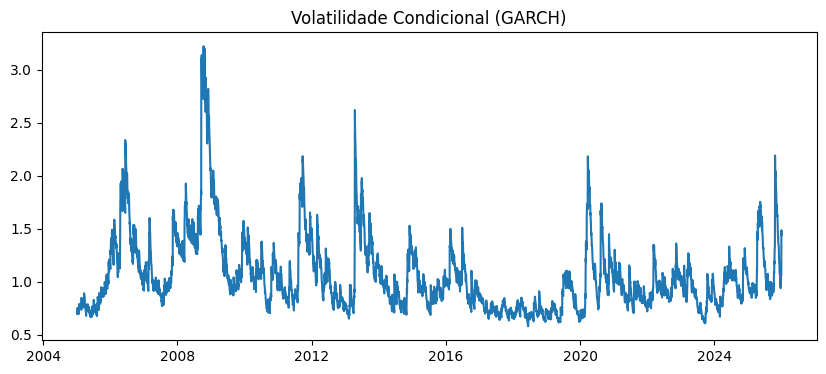

In [72]:
plt.figure(figsize=(10,4))
plt.plot(res.conditional_volatility)
plt.title("Volatilidade Condicional (GARCH)")
plt.show()

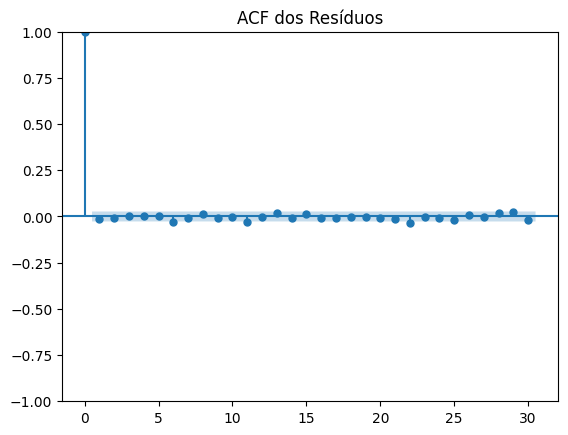

In [79]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(res.resid, lags=30)
plt.title("ACF dos Resíduos")
plt.show()

Nesse caso, o acf mostra que o garch capturou bem o efeito de heterocedasticidade, e a soma do alpha (o quanto o choque passado afeta) com o beta (a persistência da volatilidade) ser α+β=0.0573+0.9324=0.9897 revela que temos volatilidade extremamente persistente, algo típico de ativos financeiros.